# HACKATHON - PREDICCIÓN MATRICULACIONES 11-12/2021

 - Aitor Larrinoa
 - Diego Cendan

# Lectura y análisis

In [1]:
import pandas as pd

In [2]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError

In [24]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

In [27]:
from sktime.forecasting.ets import AutoETS

Leemos los datos del fichero csv.

In [3]:
df = pd.read_csv("/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/Matriculaciones (1).csv",
           sep=";", encoding="latin1", decimal=",")
df

,SERIES,PRODUCCIÓN DE TURISMOS,EXPORTACIONES DE TURISMOS,MATRICULACIONES DE TURISMOS. TOTAL
0,196001,-,-,3360.0
1,196002,-,-,4385.0
2,196003,-,-,4055.0
3,196004,-,-,5380.0
4,196005,-,-,6309.0
...,...,...,...,...
737,202106,"146311,0000000000000000","127058,0000000000000000",103467.0
738,202107,"105838,0000000000000000","89616,0000000000000000",92171.0
739,202108,"52399,0000000000000000","50770,0000000000000000",54561.0
740,202109,"141930,0000000000000000","135302,0000000000000000",67792.0


Introducimos las fechas manualmente mediante una secuencia

In [5]:
df.index=pd.date_range(end="2021-11", start="1960-01", freq="M")

In [6]:
df = df.drop("SERIES", axis=1)

In [7]:
df.columns =["Producción", "Exportaciones", "Matriculaciones"]

In [8]:
df_m = df.resample("m").last().drop(["Producción", "Exportaciones"], axis=1)

In [9]:
df = df.to_period("m")

In [10]:
df = df.drop(["Producción", "Exportaciones"], axis=1)

In [11]:
import seaborn as sns

Graficamos la serie temporal

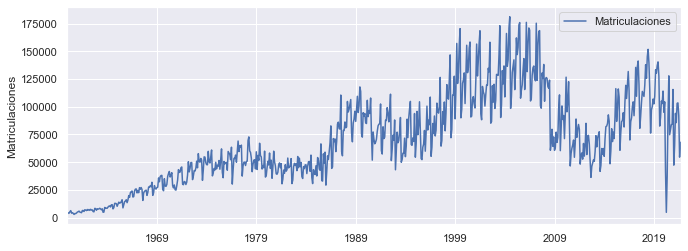

In [12]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df.plot( linestyle='-')
ax.set_ylabel('Matriculaciones');

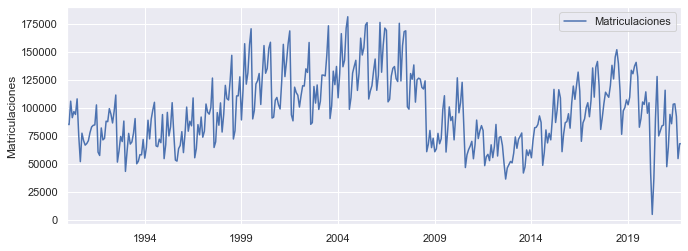

In [13]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["1990":].plot( linestyle='-')
ax.set_ylabel('Matriculaciones');

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 742 entries, 1960-01 to 2021-10
Freq: M
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Matriculaciones  742 non-null    float64
dtypes: float64(1)
memory usage: 27.8 KB


In [15]:
df_m

,Matriculaciones
1960-01-31,3360.0
1960-02-29,4385.0
1960-03-31,4055.0
1960-04-30,5380.0
1960-05-31,6309.0
...,...
2021-06-30,103467.0
2021-07-31,92171.0
2021-08-31,54561.0
2021-09-30,67792.0


Aplicamos un STL para ver tendencias y saber más o menos por donde cortar la serie temporal para analizarla más cómodamente.

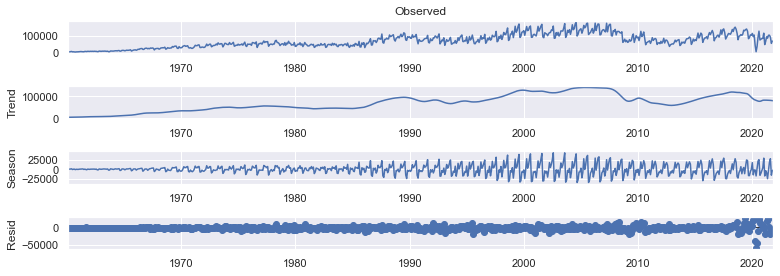

In [16]:
from statsmodels.tsa.seasonal import STL

stl = STL(df_m)
res = stl.fit()
fig = res.plot()

Cogemos la serie desde 2009, justamente después de la crisis de 2008.

In [17]:
df = df["2009":]

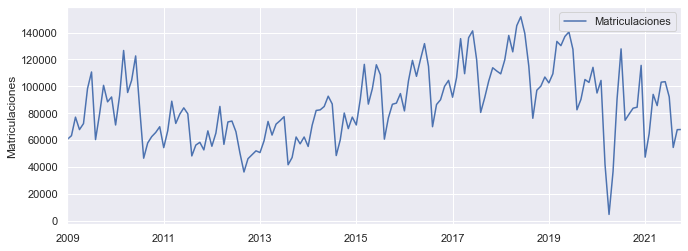

In [18]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df.plot( linestyle='-')
ax.set_ylabel('Matriculaciones');

In [19]:
df_m = df_m["2009":]

In [20]:
df

,Matriculaciones
2009-01,60662.0
2009-02,63297.0
2009-03,77102.0
2009-04,67828.0
2009-05,72303.0
...,...
2021-06,103467.0
2021-07,92171.0
2021-08,54561.0
2021-09,67792.0


In [21]:
df_m

,Matriculaciones
2009-01-31,60662.0
2009-02-28,63297.0
2009-03-31,77102.0
2009-04-30,67828.0
2009-05-31,72303.0
...,...
2021-06-30,103467.0
2021-07-31,92171.0
2021-08-31,54561.0
2021-09-30,67792.0


Volvemos a hacer un STL a nuestros nuevos datos para ver tendencia, estacionalidad de nuestros datos

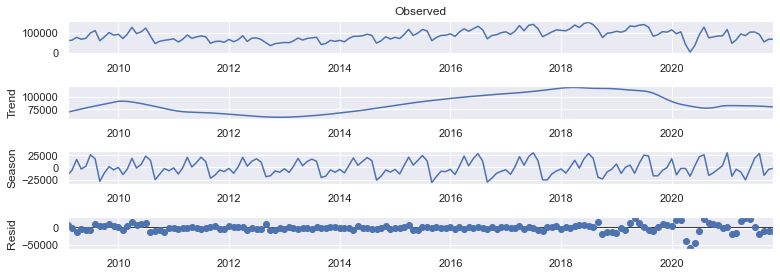

In [22]:
stl = STL(df_m)
res = stl.fit()
fig = res.plot()

Comprobamos si hay componente estacional en los meses.

Text(0.5, 1.0, 'Comportamiento Estacional')

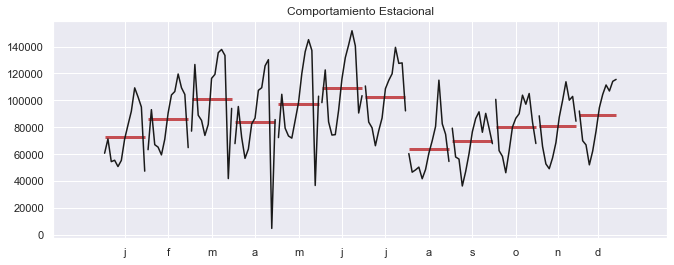

In [23]:

ax = plt.gca()
sm.graphics.tsa.month_plot(df,ax=ax)
ax.set_title('Comportamiento Estacional')


Se puede apreciar un gran impacto en las matriculaciones en los meses entre mayo y junio y desciende en agosto y septiembre. Esto puede ser debido a las vacaciones, las cuales suponen un gasto importante para mucha gente.

# MODELO ETS 

In [25]:
y = df['Matriculaciones'].astype('float64')

140 14


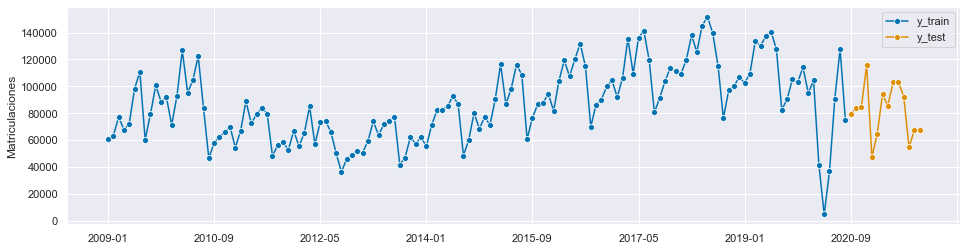

In [26]:
y_train, y_test = temporal_train_test_split(y = df['Matriculaciones'].astype('float64'), test_size=14)
# we will try to forecast y_test from y_train
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [28]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 15)  #Seleccionamos 8 muestras (del 1 al 9)
# step 3: specifying the forecasting algorithm
mat_ets = AutoETS(auto=True, sp=12, n_jobs=-1) 

In [29]:
mat_ets.fit(y_train)
print(mat_ets.summary())

                                 ETS Results                                  
Dep. Variable:        Matriculaciones   No. Observations:                  140
Model:                       ETS(MNM)   Log Likelihood               -1534.527
Date:                Mon, 20 Dec 2021   AIC                           3101.054
Time:                        16:06:23   BIC                           3148.120
Sample:                    01-31-2009   HQIC                          3120.180
                         - 08-31-2020   Scale                            0.027
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2211      0.033      6.793      0.000       0.157       0.285
smoothing_seasonal   7.789e-05        nan        nan        nan         nan         nan
initial_level   

Las predicciones se muestran a continuación

In [30]:
# step 5: querying predictions
mat_pred = mat_ets.predict(fh)
print(mat_pred)

2020-09     63782.226905
2020-10     75033.430453
2020-11     72581.680318
2020-12     77687.713080
2021-01     70084.380670
2021-02     79619.261860
2021-03     97521.892612
2021-04     83015.814318
2021-05     90903.008503
2021-06    100375.828181
2021-07     99028.096103
2021-08     60484.077906
2021-09     63782.226905
2021-10     75033.430453
Freq: M, dtype: float64


Veamos estas predicciones numéricamente.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Matriculaciones'>)

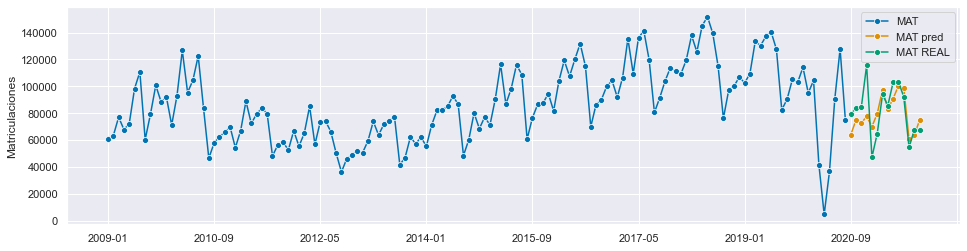

In [31]:
# optional: plotting predictions and past data
plot_series(y_train, mat_pred,y_test, labels=["MAT", "MAT pred", "MAT REAL"])

Calculamos los valores de los errores del modelo

In [32]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

MAPE_ETS=mean_absolute_percentage_error(y_test, mat_pred)
MAPE_ETS

0.14446659437663945

In [33]:
# Forecast Accuracy
#Mean Squared Error
rmse_ETS = MeanSquaredError(square_root=True)
rmse_ETS=rmse_ETS(y_test, mat_pred)
rmse_ETS

14535.792101675077

# MODELO ARIMA 

In [34]:
from sktime.transformations.series.boxcox import LogTransformer
transformer = LogTransformer()
log_mat_ts= transformer.fit_transform(df)
log_mat_ts.tail()

,Matriculaciones
2021-06,11.547008
2021-07,11.431401
2021-08,10.907075
2021-09,11.124199
2021-10,11.125777


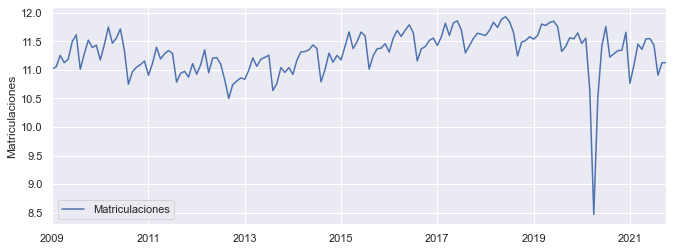

In [35]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = log_mat_ts.plot( linestyle='-')
ax.set_ylabel('Matriculaciones');

Aunque vemos claramente el efecto covid, dado que es puntual, podemos considerar que la serie logarítmica es estacionaria. Luego, separamos en train y test logarítmico.

In [36]:
log_y_train, log_y_test = temporal_train_test_split(y =log_mat_ts, test_size=14)

In [40]:
from sktime.forecasting.arima import AutoARIMA

#  Auto ARIMA Model
forecaster = AutoARIMA(sp=4,suppress_warnings=True)

#  Auto ARIMA Model Estimation
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

#  Auto ARIMA Model Summary
print(forecaster.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  140
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 4)   Log Likelihood                 -23.659
Date:                                Mon, 20 Dec 2021   AIC                             63.318
Time:                                        16:14:02   BIC                             86.793
Sample:                                             0   HQIC                            72.858
                                                - 140                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.958e-05      0.002     -0.043      0.965      -0.005       0.004
ar.

Calculamos la predicción logarítmica del modelo

In [41]:
log_y_pred = forecaster.predict(fh)
log_y_pred

,Matriculaciones
2020-09,11.104369
2020-10,11.233136
2020-11,10.633896
2020-12,9.427486
2021-01,10.569239
2021-02,11.171057
2021-03,11.027607
2021-04,9.932971
2021-05,10.593057
2021-06,11.011560


Deshacemos el cambio logarítmico para mostrar la predicción real.

In [42]:
np.exp(log_y_pred)

,Matriculaciones
2020-09,66460.882786
2020-10,75594.284890
2020-11,41518.550662
2020-12,12425.251750
2021-01,38919.042830
2021-02,71044.154988
2021-03,61550.093952
2021-04,20598.446849
2021-05,39857.148633
2021-06,60570.280079


Calculamos los errores numéricamente

In [43]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.054887769237073614

In [44]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

MAPE_ARIMA=mean_absolute_percentage_error(y_test, np.exp(log_y_pred))
MAPE_ARIMA

0.5262764848768405

In [45]:
# Forecast Accuracy
#Mean Squared Error LOG 
rmse_ARIMA_log= MeanSquaredError(square_root=True)
rmse_ARIMA_log(log_y_test, log_y_pred)

0.8285793398097872

In [46]:
# Forecast Accuracy
#Mean Squared Error
rmse_ARIMA = MeanSquaredError(square_root=True)
rmse_ARIMA= rmse_ARIMA(y_test, np.exp(log_y_pred))
rmse_ARIMA

43171.983769000464

# Comparación entre modelos

Mostramos la gráfica de las predicciones de ARIMA y ETS junto con la realidad.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Matriculaciones'>)

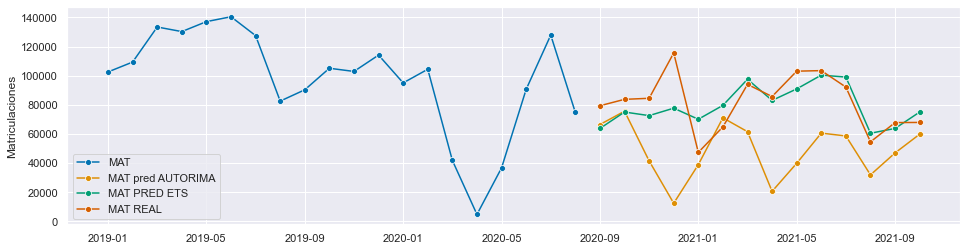

In [47]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train ['2019':], np.exp(log_y_pred), mat_pred, y_test, labels=["MAT", "MAT pred AUTORIMA", "MAT PRED ETS", "MAT REAL"])

Colocamos los errores en un data frame

In [48]:
MAPE=[MAPE_ARIMA, MAPE_ETS]
RMSE=[rmse_ARIMA, rmse_ETS]
MODELOS=['ARIMA', 'ETS']

In [49]:
data={'MAPE':MAPE, 'RMSE':RMSE}
data

{'MAPE': [0.5262764848768405, 0.14446659437663945],
 'RMSE': [43171.983769000464, 14535.792101675077]}

In [50]:
pd.DataFrame(data, columns=["MAPE",'RMSE'], index=MODELOS)

,MAPE,RMSE
ARIMA,0.526276,43171.983769
ETS,0.144467,14535.792102


Vemos como el modelo ETS se ajusta mucho mejor que el modelo ARIMA en este caso, pues su error es mucho más pequeño.

# Modelo de intervención

In [53]:
%load_ext rpy2.ipython

In [54]:
%%R 
library(tidyverse)
library(forecast)
library(tsibble)
library(feasts)
library(tsoutliers)
library(TSA)
library(xts)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: 
Attaching package: ‘tsibble’


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, union


R[write to console]: Loading required package: fabletools

R[write to console]: 
Attaching package: ‘fabletools’


R[write to console]: The following objects are masked from ‘package:forecast’:

    accuracy, forecast


R[write to console]: 
Attaching package: ‘tsoutlie

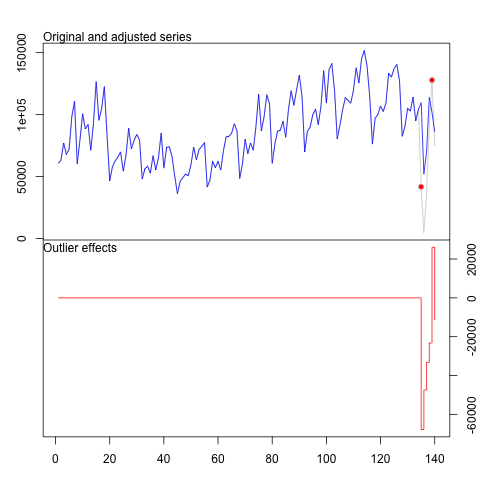

In [55]:
%%R -i y_train

library(tsoutliers)
ts=as.ts(y_train)

outliers = tso(y = ts, types = c("AO", "LS", "TC"),discard.method = "bottom-up", tsmethod = "auto.arima", args.tsmethod = list(allowdrift = FALSE, ic = "bic"))


plot.tsoutliers(outliers)

In [56]:
%%R 
print(outliers)

Series: ts 
Regression with ARIMA(0,1,2) errors 

Coefficients:
          ma1      ma2      TC135     AO139
      -0.2351  -0.5286  -67812.58  42325.42
s.e.   0.0746   0.0723   15835.58  13039.47

sigma^2 estimated as 2.75e+08:  log likelihood=-1546.21
AIC=3102.43   AICc=3102.88   BIC=3117.1

Outliers:
  type ind time coefhat  tstat
1   TC 135  135  -67813 -4.282
2   AO 139  139   42325  3.246


In [57]:
%%R 
int_data=as.ts(y_train)
dummies=data.frame(
          TC=1*(seq(y_train)==135),
          AO=1*(seq(y_train)==139))

In [58]:
%%R
mod_int=arimax(int_data,order=c(1,1,1),
        xreg=dummies,
        method='ML')
mod_int


Call:
arimax(x = int_data, order = c(1, 1, 1), xreg = dummies, method = "ML")

Coefficients:
         ar1      ma1         TC        AO
      0.5689  -0.8988  -17470.54  44716.98
s.e.  0.0991   0.0520   14971.64  14870.95

sigma^2 estimated as 3.19e+08:  log likelihood = -1558.4,  aic = 3124.8


# Sustitución COVID por valores anteriores

In [59]:
y['2020-03']=y.loc['2019-03']
y['2020-04']=y.loc['2019-04']
y['2020-05']=y.loc['2019-05']
y['2020-06']=y.loc['2019-06']
y['2020-07']=y.loc['2019-07']
y['2020-08']=y.loc['2019-08']
y['2020-09']=y.loc['2019-09']
y['2020-10']=y.loc['2019-10']
y['2020-11']=y.loc['2019-11']

In [60]:
y['2019']

2019-01    102556.0
2019-02    109343.0
2019-03    133405.0
2019-04    130254.0
2019-05    137091.0
2019-06    140445.0
2019-07    127485.0
2019-08     82549.0
2019-09     90307.0
2019-10    105084.0
2019-11    102905.0
2019-12    114131.0
Freq: M, Name: Matriculaciones, dtype: float64

In [61]:
y['2020']

2020-01     95041.0
2020-02    104396.0
2020-03    133405.0
2020-04    130254.0
2020-05    137091.0
2020-06    140445.0
2020-07    127485.0
2020-08     82549.0
2020-09     90307.0
2020-10    105084.0
2020-11    102905.0
2020-12    115580.0
Freq: M, Name: Matriculaciones, dtype: float64

Separamos en train y test considerando un horizonte de testing de dos años.

130 24


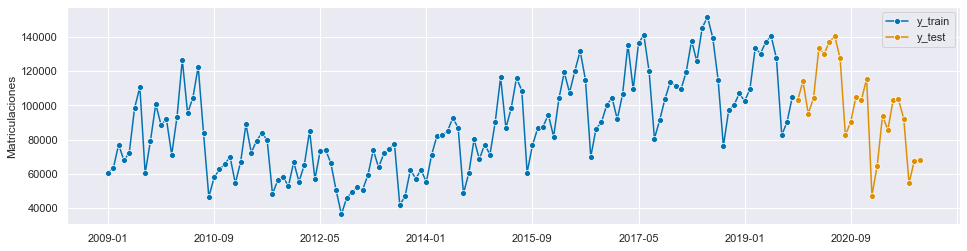

In [62]:
y_train, y_test = temporal_train_test_split(y, test_size=24)
# we will try to forecast y_test from y_train
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

# MODELO ETS SIN EFECTO COVID

In [63]:
from sktime.forecasting.ets import AutoETS

In [64]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 25)  #Seleccionamos 8 muestras (del 1 al 9)
# step 3: specifying the forecasting algorithm
mat_ets = AutoETS(auto=True, sp=12, n_jobs=-1) 

In [65]:
mat_ets.fit(y_train)
print(mat_ets.summary())

                                 ETS Results                                  
Dep. Variable:        Matriculaciones   No. Observations:                  130
Model:                       ETS(MNM)   Log Likelihood               -1359.816
Date:                lun, 20 dic 2021   AIC                           2751.632
Time:                        16:14:47   BIC                           2797.513
Sample:                    01-31-2009   HQIC                          2770.275
                         - 10-31-2019   Scale                            0.010
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6002      0.130      4.605      0.000       0.345       0.856
smoothing_seasonal   3.998e-05        nan        nan        nan         nan         nan
initial_level   

Calculamos las predicciones para después comparar con el testing

In [66]:
# step 5: querying predictions
mat_pred = mat_ets.predict(fh)
print(mat_pred)

2019-11    102739.591414
2019-12    109658.426706
2020-01     97346.158187
2020-02    113143.722873
2020-03    139466.565412
2020-04    117479.771866
2020-05    130428.413383
2020-06    142417.599336
2020-07    131322.016337
2020-08     82118.606492
2020-09     90171.244874
2020-10    105094.590322
2020-11    102739.591414
2020-12    109658.426706
2021-01     97346.158187
2021-02    113143.722873
2021-03    139466.565412
2021-04    117479.771866
2021-05    130428.413383
2021-06    142417.599336
2021-07    131322.016337
2021-08     82118.606492
2021-09     90171.244874
2021-10    105094.590322
Freq: M, dtype: float64


A continuación vemos si nuestro modelo es correcto comparando con el testing.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Matriculaciones'>)

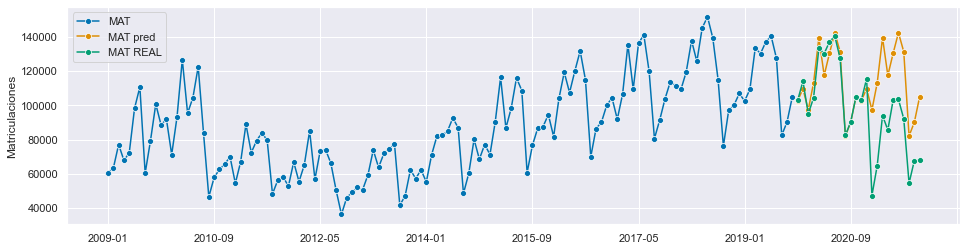

In [67]:
# optional: plotting predictions and past data
plot_series(y_train, mat_pred,y_test, labels=["MAT", "MAT pred", "MAT REAL"])

Dado que la imagen no nos proporciona información numérica, calculamos los valores del error.

In [68]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

MAPE_ETS_mod=mean_absolute_percentage_error(y_test, mat_pred)
MAPE_ETS_mod

0.1834335522914754

In [69]:
# Forecast Accuracy
#Mean Squared Error
rmse_ETS_mod = MeanSquaredError(square_root=True)
rmse_ETS_mod=rmse_ETS_mod(y_test, mat_pred)
rmse_ETS_mod

24793.080118137346

# MODELO ARIMA SIN EFECTO COVID

Separamos en train y test el dataset con logaritmo

In [70]:
log_y_train, log_y_test = temporal_train_test_split(y =log_mat_ts, test_size=24)

In [71]:
from sktime.forecasting.arima import AutoARIMA

#  Auto ARIMA Model
forecaster = AutoARIMA(sp=4,suppress_warnings=True)

#  Auto ARIMA Model Estimation
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

#  Auto ARIMA Model Summary
print(forecaster.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  130
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 4)   Log Likelihood                  54.008
Date:                                lun, 20 dic 2021   AIC                            -94.015
Time:                                        16:14:54   BIC                            -73.996
Sample:                                             0   HQIC                           -85.881
                                                - 130                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.267e-05      0.001      0.068      0.945      -0.001       0.002
ar.

Realizamos la predicción logarítmica del modelo ARIMA

In [72]:
log_y_pred = forecaster.predict(fh)
log_y_pred

,Matriculaciones
2019-11,11.627845
2019-12,11.818279
2020-01,11.536406
2020-02,11.646274
2020-03,11.677793
2020-04,11.599168
2020-05,11.513721
2020-06,11.599230
2020-07,11.634766
2020-08,11.571050


Deshacemos el cambio logarítmico elevanto todo a *e*.

In [73]:
np.exp(log_y_pred)

,Matriculaciones
2019-11,112178.340182
2019-12,135710.434895
2020-01,102375.832141
2020-02,114264.842091
2020-03,117923.723817
2020-04,109007.074506
2020-05,100079.624814
2020-06,109013.858546
2020-07,112957.411926
2020-08,105984.663299


Calculamos los valores MAPE y RMSE para el modelo

In [74]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.03901944765667468

In [75]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

MAPE_ARIMA_mod=mean_absolute_percentage_error(y_test, np.exp(log_y_pred))
MAPE_ARIMA_mod

0.20667900820818388

In [76]:
# Forecast Accuracy
#Mean Squared Error
rmse_ARIMA_mod = MeanSquaredError(square_root=True)
rmse_ARIMA_mod= rmse_ARIMA_mod(y_test, np.exp(log_y_pred))
rmse_ARIMA_mod

23945.028476586325

# Comparación entre modelos sin efecto covid

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Matriculaciones'>)

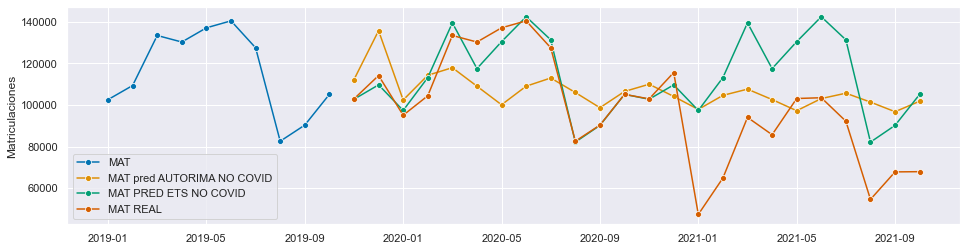

In [77]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train ['2019':], np.exp(log_y_pred), mat_pred, y_test, labels=["MAT", "MAT pred AUTORIMA NO COVID", "MAT PRED ETS NO COVID", "MAT REAL"])

Unimos todas las métricas de error utilizadas y las juntamos en un data frame para que la comparación sea más visual

In [78]:
MAPE=[MAPE_ETS_mod, MAPE_ARIMA_mod]
RMSE=[rmse_ETS_mod, rmse_ARIMA_mod]
MODELOS=['ETS_mod', 'ARIMA_mod']

In [79]:
data={'MAPE':MAPE, 'RMSE':RMSE}
data

{'MAPE': [0.1834335522914754, 0.20667900820818388],
 'RMSE': [24793.080118137346, 23945.028476586325]}

In [80]:
pd.DataFrame(data, columns=["MAPE",'RMSE'], index=MODELOS)

,MAPE,RMSE
ETS_mod,0.183434,24793.080118
ARIMA_mod,0.206679,23945.028477


Parece que el modelo ETS tiene menor MAPE pero, tiene mayor RMSE. Aun así, los dos modelos están muy parejos en este caso.

# COMPARACIÓN Y SELECCIÓN DE MODELO FINAL 

Comparamos todos los modelos poniendo todos los erroes obtenidos en un data frame

In [81]:
MAPE=[MAPE_ARIMA, MAPE_ETS, MAPE_ETS_mod, MAPE_ARIMA_mod]
RMSE=[rmse_ARIMA, rmse_ETS, rmse_ETS_mod, rmse_ARIMA_mod]
MODELOS=['ARIMA', 'ETS', 'ETS_mod', 'ARIMA_mod']

In [82]:
data={'MAPE':MAPE, 'RMSE':RMSE}
data

{'MAPE': [0.5262764848768405,
  0.14446659437663945,
  0.1834335522914754,
  0.20667900820818388],
 'RMSE': [43171.983769000464,
  14535.792101675077,
  24793.080118137346,
  23945.028476586325]}

In [83]:
pd.DataFrame(data, columns=["MAPE",'RMSE'], index=MODELOS)

,MAPE,RMSE
ARIMA,0.526276,43171.983769
ETS,0.144467,14535.792102
ETS_mod,0.183434,24793.080118
ARIMA_mod,0.206679,23945.028477


Elegimos el modelo ETS para la predicción final puesto que como hemos podido comprobar en su respectiva gráfica en comparacion con la realidad y se observa en la tabla de errores, es el mejor modelo.

# PREDICCIÓN MODELO FINAL ETS 

In [84]:
df=df['Matriculaciones'].astype('float64')

In [85]:
mat_ets_todo=mat_ets.fit(df)
print(mat_ets_todo.summary())

                                 ETS Results                                  
Dep. Variable:        Matriculaciones   No. Observations:                  154
Model:                       ETS(MNM)   Log Likelihood               -1688.788
Date:                lun, 20 dic 2021   AIC                           3409.576
Time:                        16:14:55   BIC                           3458.167
Sample:                    01-31-2009   HQIC                          3429.314
                         - 10-31-2021   Scale                            0.028
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2155      0.033      6.447      0.000       0.150       0.281
smoothing_seasonal   7.845e-05        nan        nan        nan         nan         nan
initial_level   

Los valores numéricos de las predicciones que nos interesan se muestran a continuación.

In [86]:
mat_pred_todo = mat_ets.predict(np.arange(1,3)).astype('int')
print(mat_pred_todo)

2021-11    71674
2021-12    79272
Freq: M, dtype: int64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Matriculaciones'>)

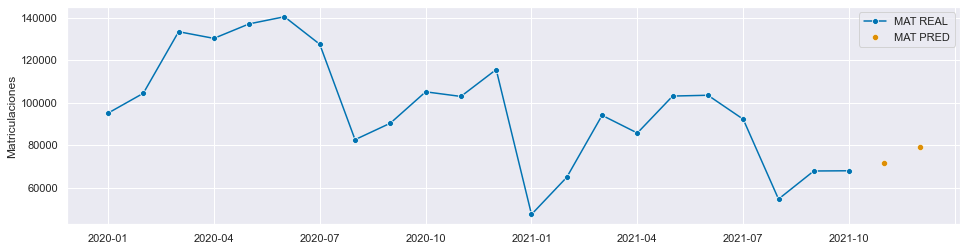

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/exponential_smoothing/ets.py:1135: RuntimeWarning: invalid value encountered in log
  logL -= np.sum(np.log(yhat))
/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [87]:
# optional: plotting predictions and past data
plot_series(y['2020':], mat_pred_todo, labels=["MAT REAL", "MAT PRED"])

**Estimamos una preddición de 71674 matriculaciones para el mes de Noviembre y 79272 para el mes de Diciembre**